# Train a CNN based on the InceptionV3 architecture to recognize kitharai
*Adapted from the [Keras Applications](https://keras.io/api/applications/) page and [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).*  

*This is the base model for the project, trained on 75% of the 410 kitharai in the dataset and 75% of a random sample of 5,000 non-kithara images.*

In [1]:
# import libraries from tensorflow keras (for model building), sklearn (for metrics), matplotlib (for visualization), and np/os/pd (for data processing)
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models, applications, layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Set up the training / testing (75/25) datasets

In [3]:
# create absolute path to location of images
data_dir = os.path.dirname(os.getcwd()) + '\\data\\images-model\\inceptionv3\\'

# create alternate absolute paths for a pre-split training / testing dataset
data_dir_train = os.path.dirname(os.getcwd()) + '\\data\\images-model\\train\\'
data_dir_test = os.path.dirname(os.getcwd()) + '\\data\\images-model\\test\\'

# show the paths created
# print(data_dir)
# print(data_dir_train)
# print(data_dir_test)

In [4]:
# set variables for the model here
# number of images per batch
batch_size = 32

# all images have been resized to 558x558 pixels, the median size of a kithara in the dataset
img_height = 558
img_width = 558

#### Option 1: Generate the train/test split from the `image_dataset_from_directory` call

In [5]:
# # create a training and testing dataset from the pre-processed images
# # this code generates the train/test split within the image_dataset_from_directory call
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.25,
#   subset="training",
#   seed=42,
#   image_size=(img_height, img_width),
#   batch_size=batch_size,
#   label_mode = 'categorical')

# # create a testing dataset from the pre-processed images
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.25,
#   subset="validation",
#   seed=42,
#   image_size=(img_height, img_width),
#   batch_size=batch_size,
#   label_mode = 'categorical')

#### Option 2: Use the train/test split from notebook 02
*Note that `shuffle = True` [by default](https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima). Explicitly set `shuffle = False` for the test dataset in order to ensure alignment across the labels and file names (see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)).*

In [6]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical')

# create a testing dataset from the pre-processed images
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels = 'inferred',
    shuffle = False, # make sure that shuffle is off to be able to identify test filepaths
    label_mode = 'categorical')

Found 4057 files belonging to 2 classes.
Found 1353 files belonging to 2 classes.


#### Get some identifying information about the files in the test dataset

In [7]:
# create a variable to store the filepaths for the files in the val_ds dataframe
# we'll need this later to align the image IDs with the predictions
filepaths = test_ds.file_paths
# check the filepaths list created
# filepaths

In [8]:
# get the inferred labels (0 = kithara, 1 = no-kithara) for the test dataset
test_labels = [np.argmax(y.numpy(), axis = -1) for _, y in test_ds]
# print(test_labels)
test_labels = np.concatenate(test_labels)
# print(test_labels)
print(len(test_labels))

1353


In [9]:
# check that the class names are as anticipated
class_names = train_ds.class_names
print(class_names)

['kithara', 'no-kithara']


In [10]:
# check the batch shapes and number of labels in the training dataset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 558, 558, 3)
(32, 2)


#### Optimize the dataset for processing

*Note that the following cell is intended to improve the performance of the model and overall memory / CPU usage, in line with the [Keras Performance Recommendations](https://www.tensorflow.org/datasets/performances). The cells below subsequently normalize the pixel values to between 0 and 1.*

In [11]:
# use prefetch to optimize run time
# use tf.data.autotune to automatically adjust the buffer size
AUTOTUNE = tf.data.AUTOTUNE

# make the training data easier to process
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# normalize the 0 to 255 values in the color images to between 0 and 1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
# create a normalized training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03137255 0.82745105


In [14]:
# create a normalized testing dataset
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011764707 0.94117653


### Build a base model from the inceptionv3 model architecture

In [15]:
# create the base pre-trained model
# note that if this does not run, downgrade h5py
# pip install "h5py==2.10.0" --force-reinstall
base_model = applications.InceptionV3(weights = 'imagenet',
                                      include_top=False,
                                      input_shape = (img_height, img_width, 3))

#### Add customizations to the base model for model

In [16]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and add a logistic layer -- output should be the number of classes (in this case, 2)
predictions = Dense(2, activation='softmax')(x)

In [17]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['BinaryAccuracy',
                        'FalseNegatives',
                        'FalsePositives',
                        'TrueNegatives',
                        'TruePositives',
                        'AUC',
                        'Precision',
                        'Recall'])

In [20]:
# take a look at the model layer-by-layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 558, 558, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 278, 278, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 278, 278, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 278, 278, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Create checkpoints for the model

In [21]:
checkpoint_path = 'model_checkpoints/training_01/cp-{epoch}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights after each training run
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq = 'epoch')

### Fit model on the normalized training data

In [22]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 8

# fit the model based on the normalized training data
# write the comparative metrics on the normalized training and testing data to history
history = model.fit(
    normalized_ds,
    validation_data = normalized_test_ds,
    epochs=epochs,
    callbacks = [cp_callback]
    )

Epoch 1/2
127/127 [==============================] - 1287s 10s/step - loss: 0.2081 - binary_accuracy: 0.9261 - false_negatives: 300.0000 - false_positives: 300.0000 - true_negatives: 3757.0000 - true_positives: 3757.0000 - auc: 0.9725 - precision: 0.9261 - recall: 0.9261 - val_loss: 0.1355 - val_binary_accuracy: 0.9313 - val_false_negatives: 93.0000 - val_false_positives: 93.0000 - val_true_negatives: 1260.0000 - val_true_positives: 1260.0000 - val_auc: 0.9849 - val_precision: 0.9313 - val_recall: 0.9313

Epoch 00001: saving model to model_checkpoints/training_01\cp-1.ckpt
Epoch 2/2
127/127 [==============================] - 1377s 11s/step - loss: 0.1224 - binary_accuracy: 0.9482 - false_negatives: 210.0000 - false_positives: 210.0000 - true_negatives: 3847.0000 - true_positives: 3847.0000 - auc: 0.9860 - precision: 0.9482 - recall: 0.9482 - val_loss: 0.0829 - val_binary_accuracy: 0.9660 - val_false_negatives: 46.0000 - val_false_positives: 46.0000 - val_true_negatives: 1307.0000 - val

In [23]:
# save the model to utilize later
model.save('saved_models/model-01')

INFO:tensorflow:Assets written to: saved_models/model-01\assets


### Predict the probability that an image contains a kithara based on model

In [24]:
# predict the probability of kithara / no-kithara label of the normalized_val_ds images
# N.B. COMMENT OUT THIS CELL ONCE IT HAS BEEN RUN TO PREVENT ACCIDENTALLY RE-RUNNING IT
test_predictions = model.predict(normalized_test_ds)

In [25]:
# check the min/max probabilities of predicted kithara / no-kithara labels
print(test_predictions.min(axis = 0))
print(test_predictions.max(axis = 0))

# print the names of the classes for clarity
print(class_names)

# return the array of predictions
print(test_predictions)

[4.5776395e-14 1.0641827e-03]
[0.99893576 1.        ]
['kithara', 'no-kithara']
[[5.1420975e-01 4.8579025e-01]
 [9.9322492e-01 6.7750593e-03]
 [3.8048737e-03 9.9619508e-01]
 ...
 [2.3437685e-09 1.0000000e+00]
 [2.2784830e-10 1.0000000e+00]
 [6.0073183e-11 1.0000000e+00]]


*The cell below converts the array of probabilities into a class prediction for a binary yes/no response to 'is it a kithara?' The probability threshold for determining whether or not an image contains a kithara can be adjusted here.*

In [26]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class = (test_predictions[:,1]>=0.5).astype(int)
print(predicted_class)

[0 0 1 ... 1 1 1]


### Performance analysis
*Performance analysis for this model, an 8-epoch inceptionv3 instance with two additional layers trained on images that have only been normalized to 0-1 per pixel value.*

In [27]:
# take a look at the metrics from each epoch
history.history

{'loss': [0.20814992487430573, 0.12241891026496887],
 'binary_accuracy': [0.9260537624359131, 0.9482375979423523],
 'false_negatives': [300.0, 210.0],
 'false_positives': [300.0, 210.0],
 'true_negatives': [3757.0, 3847.0],
 'true_positives': [3757.0, 3847.0],
 'auc': [0.972537636756897, 0.9860129952430725],
 'precision': [0.9260537624359131, 0.9482375979423523],
 'recall': [0.9260537624359131, 0.9482375979423523],
 'val_loss': [0.13546648621559143, 0.08286495506763458],
 'val_binary_accuracy': [0.9312638640403748, 0.9660014510154724],
 'val_false_negatives': [93.0, 46.0],
 'val_false_positives': [93.0, 46.0],
 'val_true_negatives': [1260.0, 1307.0],
 'val_true_positives': [1260.0, 1307.0],
 'val_auc': [0.9848909378051758, 0.9937595129013062],
 'val_precision': [0.9312638640403748, 0.9660014510154724],
 'val_recall': [0.9312638640403748, 0.9660014510154724]}

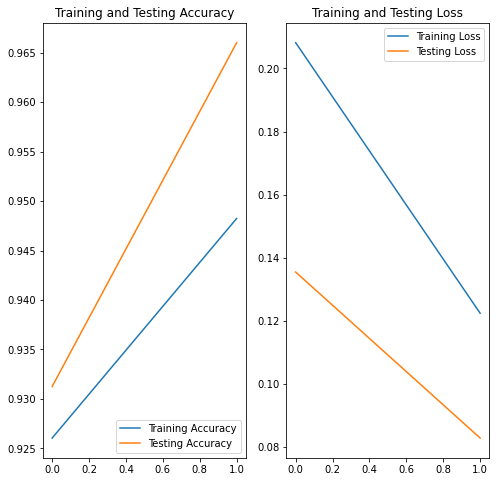

In [28]:
# visualize the model's performance epoch-by-epoch

# set accuracy variables
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# set loss variables
loss = history.history['loss']
val_loss = history.history['val_loss']

# set epoch range
epochs_range = range(epochs)

# plot accuracy for training vs. testing dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

# plot loss for training vs. testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [29]:
# print the accuracy of the kithara identification compared to the predicted class with the threshold set above
print(accuracy_score(test_labels, predicted_class))

# print the AUC for the model
print(roc_auc_score(test_labels, test_predictions[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print(classification_report(test_labels, predicted_class, target_names = class_names))

0.9660014781966001
0.9837281553398058
              precision    recall  f1-score   support

     kithara       0.80      0.74      0.77       103
  no-kithara       0.98      0.98      0.98      1250

    accuracy                           0.97      1353
   macro avg       0.89      0.86      0.87      1353
weighted avg       0.96      0.97      0.97      1353



In [30]:
# create a dataframe to hold the filenames, actual values, and predicted no-kithara probability
pred_df = pd.DataFrame({'filepath': filepaths, 'actuals': test_labels, 'predictions': test_predictions[:,0]})

# take a look at the dataframe where the known value was a kithara
pred_df[pred_df['actuals'] == 0].sort_values('predictions')

,filepath,actuals,predictions
6,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0077-kithara-full.jpg,0,0.000009
74,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG8619-kithara-full.jpg,0,0.000414
92,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9864b-kithara-full.jpg,0,0.000476
2,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0045-kithara-full.jpg,0,0.003805
96,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9870a-kithara-full.jpg,0,0.009865
26,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0745-kithara-full.jpg,0,0.011897
36,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG1542-kithara-full.jpg,0,0.015115
75,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG8804b-kithara-full.jpg,0,0.017028
38,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG1568b-kithara-full.jpg,0,0.032244
97,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9871b-kithara-full.jpg,0,0.057722


In [ ]:
# # check to see if specific images are included in the training dataset
# pred_df[pred_df['filepath'].str.contains('IMAG9081')]